In [1]:
using FundamentalsNumericalComputation
FNC.init_format()

┌ Info: verify download of index files...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/MatrixDepot.jl:139
┌ Info: reading database
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:23
┌ Info: adding metadata...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:67
┌ Info: adding svd data...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:69
┌ Info: writing database
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:74
┌ Info: used remote sites are sparse.tamu.edu with MAT index and math.nist.gov with HTML index
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/MatrixDepot.jl:141


(section-krylov-gmres)=
# GMRES

The most important use of the Arnoldi iteration is to solve the square linear system $\mathbf{A}\mathbf{x}=\mathbf{b}$. 

In {numref}`Demo {number} <demo-subspace-unstable>`, we attempted to replace the linear system $\mathbf{A}\mathbf{x}=\mathbf{b}$ by the lower-dimensional approximation

:::{math}
\min_{\mathbf{x}\in \mathcal{K}_m} \|  \mathbf{A}\mathbf{x}-\mathbf{b}  \| = \min_{\mathbf{z}\in\mathbb{C}^m} \|   \mathbf{A}\mathbf{K}_m\mathbf{z}-\mathbf{b}  \|,
:::

where $\mathbf{K}_m$ is the Krylov matrix generated using $\mathbf{A}$ and the seed vector $\mathbf{b}$. This method was unstable due to the poor conditioning of $\mathbf{K}_m$, which is a numerically poor basis for $\mathcal{K}_m$. 

The Arnoldi algorithm yields an orthonormal basis of the same space and fixes the stability problem. Set $\mathbf{x}=\mathbf{Q}_m\mathbf{z}$ and obtain

:::{math}
:label: gmresproblem
\min_{\mathbf{z}\in\mathbb{C}^m}\, \bigl\| \mathbf{A} \mathbf{Q}_m \mathbf{z}-\mathbf{b}  \bigr\|.
:::

From the fundamental Arnoldi identity {eq}`arnoldimat`, this is equivalent to

:::{math}
:label: gmresproblem1
\min_{\mathbf{z}\in\mathbb{C}^m}\, \bigl\| \mathbf{Q}_{m+1} \mathbf{H}_m\mathbf{z}-\mathbf{b} \bigr\|.
:::

Note that $\mathbf{q}_1$ is a unit multiple of $\mathbf{b}$, so $\mathbf{b} = \|\mathbf{b}\| \mathbf{Q}_{m+1}\mathbf{e}_1$. Thus {eq}`gmresproblem1` becomes

:::{math}
:label: gmresproblem2
\min_{\mathbf{z}\in\mathbb{C}^m}\, \bigl\| \mathbf{Q}_{m+1} (\mathbf{H}_m\mathbf{z}-\|\mathbf{b}\|\mathbf{e}_1) \bigr\|.
:::


The least-squares problems {eq}`gmresproblem`,  {eq}`gmresproblem1`, and {eq}`gmresproblem2` are all $n\times m$. But observe that for any $\mathbf{w}\in\mathbb{C}^{m+1}$,

:::{math}
  \|\mathbf{Q}_{m+1}\mathbf{w}\|^2 = \mathbf{w}^*\mathbf{Q}_{m+1}^*\mathbf{Q}_{m+1}\mathbf{w} = \mathbf{w}^*\mathbf{w} = \|\mathbf{w}\|^2.
:::

The first norm in that equation is on $\mathbb{C}^n$, while the last is on the much smaller space $\mathbb{C}^{m+1}$. Hence the least-squares problem {eq}`gmresproblem2` is equivalent to

:::{math}
  :label: gmresproblemsmall
  \min_{\mathbf{z}\in\mathbb{C}^m}\, \bigl\| \mathbf{H}_m\mathbf{z}-\|\mathbf{b}\|\,\mathbf{e}_1 \bigr\|,
:::

which is of size $(m+1)\times m$. We call the solution of this minimization $\mathbf{z}_m$, and then $\mathbf{x}_m=\mathbf{Q}_m \mathbf{z}_m$ is the $m$th approximation to the solution of $\mathbf{A}\mathbf{x}=\mathbf{b}$.

```{index} ! GMRES
```
::::{proof:algorithm} GMRES
Given $n\times n$ matrix $\mathbf{A}$ and $n$-vector $\mathbf{b}$:

For $m=1,2,\ldots$, let $\mathbf{x}_m=\mathbf{Q}_m \mathbf{z}_m$, where $\mathbf{z}_m$ solves the linear least-squares problem {eq}`gmresproblemsmall`, and $\mathbf{Q}_m,\mathbf{H}_m$ arise from the Arnoldi iteration.
::::


GMRES[^gmres] uses the Arnoldi iteration to minimize the residual $\mathbf{b} - \mathbf{A}\mathbf{x}$ over successive Krylov subspaces. In exact arithmetic, GMRES should get the exact solution when $m=n$, but the goal is to reduce the residual enough to stop at some $m \ll n$.[^breakdown]

[^gmres]: GMRES stands for Generalized Minimum RESidual. We will encounter its precursor MINRES in {numref}`section-krylov-minrescg`.

[^breakdown]: This statement is not strictly correct for rare special cases of *breakdown* where the rank of $\mathcal{K}_n$ is less than $n$. In that situation, some additional steps must be taken that we do not discuss here.

(demo-gmres-intro)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

We define a triangular matrix with known eigenvalues and a random vector $\mathbf{b}$.

In [2]:
λ = @. 10 + (1:100)
A = triu(rand(100,100),1) + diagm(λ)
b = rand(100);

Instead of building the Krylov matrices, we use the Arnoldi iteration to generate equivalent orthonormal vectors.

In [3]:
Q,H = FNC.arnoldi(A,b,60);

The Arnoldi bases are used to solve the least-squares problems defining the GMRES iterates.

In [4]:
resid = [norm(b);zeros(60)]
for m in 1:60  
    s = [norm(b); zeros(m)]
    z = H[1:m+1,1:m]\s
    x = Q[:,1:m]*z
    resid[m+1] = norm(b-A*x)
 end

The approximations converge smoothly, practically all the way to machine epsilon.

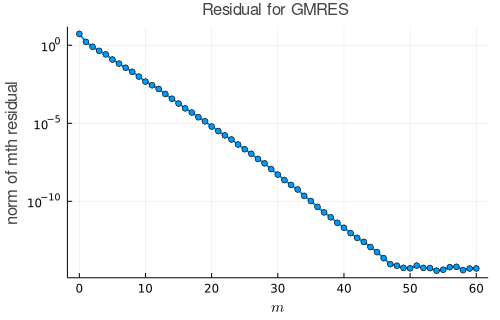

In [5]:
plot(0:60,resid,m=:o,
    xaxis=(L"m"),yaxis=(:log10,"norm of mth residual"), 
    title="Residual for GMRES",leg=:none)

```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```

Compare the graph in {numref}`Demo %s <demo-gmres-intro>`  to the one in {numref}`Demo %s <demo-subspace-unstable>`. Both start with the same linear convergence, but only the version using Arnoldi avoids the instability created by the poor Krylov basis.

A basic implementation of GMRES is given in {numref}`Function {number} <function-gmres>`.

(function-gmres)=
````{proof:function} gmres
**GMRES for a linear system**

```{code-block} julia1
:lineno-start: 1
"""
    gmres(A,b,m)

Do `m` iterations of GMRES for the linear system `A`*x=`b`. Returns
the final solution estimate x and a vector with the history of
residual norms. (This function is for demo only, not practical use.)
"""
function gmres(A,b,m)
    n = length(b)
    Q = zeros(n,m+1)
    Q[:,1] = b/norm(b)
    H = zeros(m+1,m)

    # Initial solution is zero.
    x = 0
    residual = [norm(b);zeros(m)]

    for j in 1:m
        # Next step of Arnoldi iteration.
        v = A*Q[:,j]
        for i in 1:j
            H[i,j] = dot(Q[:,i],v)
            v -= H[i,j]*Q[:,i]
        end
        H[j+1,j] = norm(v)
        Q[:,j+1] = v/H[j+1,j]

        # Solve the minimum residual problem.
        r = [norm(b); zeros(j)]
        z = H[1:j+1,1:j] \ r
        x = Q[:,1:j]*z
        residual[j+1] = norm( A*x - b )
    end
    return x,residual
end
```
````

## Convergence and restarting

Thanks to {numref}`Theorem %s <theorem-subspace-krylovmult>`, minimization of $\|\mathbf{b}-\mathbf{A}\mathbf{x}\|$ over $\mathcal{K}_{m+1}$ includes minimization over $\mathcal{K}_m$. Hence the norm of the residual $\mathbf{r}_m = \mathbf{b} - \mathbf{A}\mathbf{x}_m$ (being the minimized quantity) cannot increase as the iteration unfolds.

```{index} convergence rate; linear
```

Unfortunately, making other conclusive statements about the convergence of GMRES is neither easy nor simple. {numref}`Demo %s <demo-gmres-intro>` shows the cleanest behavior: essentially linear convergence down to the range of machine epsilon. But it is possible for the convergence to go through phases of sublinear and superlinear convergence as well. There is a strong dependence on the eigenvalues of the matrix, a fact we state with more precision and detail in the next section.

```{index} ! GMRES; restarting
```

One of the practical challenges in GMRES is that as the dimension of the Krylov subspace grows, the number of new entries to be found in $\mathbf{H}_m$ and the total number of columns in $\mathbf{Q}$ also grow. Thus both the work and the storage requirements are quadratic in $m$, which can become intolerable in some applications. For this reason, GMRES is often used with **restarting**.

Suppose $\hat{\mathbf{x}}$ is an approximate solution of $\mathbf{A}\mathbf{x}=\mathbf{b}$. Then if we set $\mathbf{x}=\mathbf{u}+\hat{\mathbf{x}}$, we have $\mathbf{A}(\mathbf{u}+\hat{\mathbf{x}}) = \mathbf{b}$, or $\mathbf{A}\mathbf{u} = \mathbf{b} - \mathbf{A}\hat{\mathbf{x}}$. The conclusion is that if we get an approximate solution and compute its residual $\mathbf{r}=\mathbf{b} - \mathbf{A}\hat{\mathbf{x}}$, then we need only to solve $\mathbf{A}\mathbf{u} = \mathbf{r}$ in order to get a correction to $\hat{\mathbf{x}}$.[^relativerestart]

[^relativerestart]: The new problem needs to be solved for accuracy relative to $\|\mathbf{b}\|$, *not* relative to $\|\mathbf{r}\|$.

Restarting guarantees a fixed upper bound on the per-iteration cost of GMRES. However, this benefit comes at a price. Even though restarting preserves progress made in previous iterations, the Krylov space information is discarded and the residual minimization process starts again over low-dimensional spaces. That can significantly retard or even stagnate the convergence. 

(demo-gmres-restart)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

The following experiments are based on a matrix resulting from discretization of a partial differential equation.

```{index} Julia; keyword function arguments
```

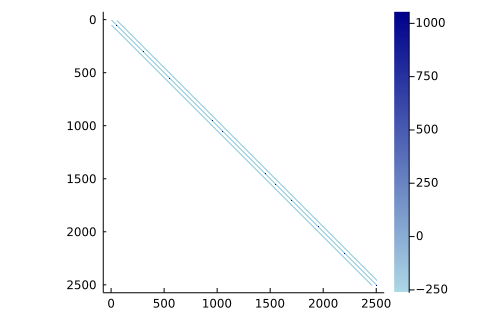

In [6]:
A = FNC.poisson(50)
n = size(A,1)
b = ones(n);
spy(A,color=:blues)

```{index} ! Julia; gmres
```

::::{panels}
:column: col-7 left-side
:card: border-0 shadow-none
```{raw} latex
\begin{minipage}[t]{0.5\textwidth}
```
We compare unrestarted GMRES with three different thresholds for restarting. Here we are using `gmres` from the `IterativeSolvers` package, since our simple implementation does not offer restarting.

```{raw} latex
\end{minipage}\hfill
```
---
:column: col-5 right-side
:card: shadow-none comment
```{raw} latex
\begin{minipage}[t]{0.4\textwidth}\begin{mdframed}[default]\small
```
The syntax `f(x;foo)` is shorthand for `f(x,foo=foo)`.
```{raw} latex
\end{mdframed}\end{minipage}
```
::::

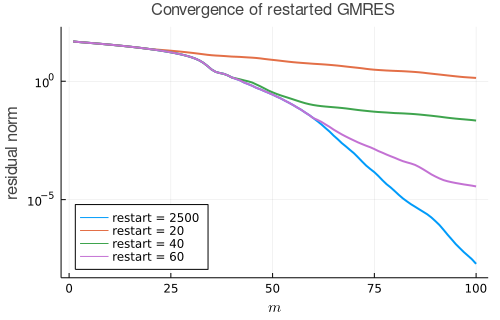

In [7]:
reltol = 1e-12;
plt = plot(title="Convergence of restarted GMRES",leg=:bottomleft,
    xaxis=(L"m"), yaxis=(:log10,"residual norm",[1e-8,100]))

for restart in [n,20,40,60]
    x,hist = IterativeSolvers.gmres(A,b;restart,reltol,
                                    maxiter=100,log=true)
    plot!(hist[:resnorm],label="restart = $restart")
end

plt

The "pure" GMRES curve is the lowest one. All of the other curves agree with it until the first restart. Decreasing the restart value makes the convergence per iteration generally worse, but the time required per iteration smaller as well.
```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```

Restarting creates a tradeoff between the number of iterations and the speed per iteration. It's essentially impossible in general to predict the ideal restart location in any given problem, so one goes by experience and hopes for the best.

There are other ways to avoid the growth in computational effort as the GMRES/Arnoldi iteration proceeds. Three of the more popular variations are abbreviated CGS, BiCGSTAB, and QMR. We do not describe them in this book.

## Exercises

1. ✍ (See also [Exercise 8.4.1](problem-krylovpermute).) Consider the linear system with
  
    $$
    \mathbf{A}=\displaystyle 
    \begin{bmatrix}
      0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \\ 1 & 0 & 0 & 0
    \end{bmatrix}, \qquad \mathbf{b}=\mathbf{e}_1.
    $$

    **(a)** Find the exact solution by inspection.

    **(b)** Find the GMRES approximate solutions $\mathbf{x}_m$ for $m=1,2,3,4$. 

2. ✍ (Continuation of [Exercise 8.4.3](problem-subspace-matrixpolykrylov).) Show that if $\mathbf{x}_m\in\mathcal{K}_m$, then the residual $\mathbf{b}-\mathbf{A}\mathbf{x}_m$ is equal to $q(\mathbf{A})\mathbf{b}$, where $q$ is a polynomial of degree at most $m$ and $q(0)=1$. (This fact is a key one for many convergence results.) 

3. ✍ Explain why GMRES, in exact arithmetic, converges to the true solution in $n$ iterations for an $n\times n$ matrix if $\operatorname{rank}(\mathbf{K}_n)=n$. (Hint: Consider how the algorithm is defined from first principles.) 

4. ⌨ Let $\mathbf{A}$ be the $n\times n$ tridiagonal matrix
  
    $$
    \begin{bmatrix}
      -4 & 1      &        &        &   \\
      1  & -4     & 1      &        &   \\
         & \ddots & \ddots & \ddots &   \\
         &        & 1      & -4     & 1 \\
         &        &        & 1      & -4 
    \end{bmatrix}
    $$
  
    and let the $n$-vector $\mathbf{b}$ have elements $b_i=i/n$. For $n=8,16,32,64$, run {numref}`Function {number} <function-gmres>` for $m=n/2$ iterations. On one semi-log graph, plot $\|\mathbf{r}_k\|/\|\mathbf{b}\|$ for all the cases. How does the convergence rate of GMRES seem to depend on $n$?  

    % must stay as #5
    (problem-gmres-surround)=
5. ⌨  In this exercise you will see the strong effect the eigenvalues of the matrix may have on GMRES convergence. Let 
   
    $$
    \mathbf{B}=
    \begin{bmatrix}
      1 & & & \\
      & 2 & & \\
      & & \ddots & \\
      & & & 100
    \end{bmatrix},
    $$ 
    
    let $\mathbf{I}$ be a $100\times 100$ identity, and let $\mathbf{Z}$ be a $100\times 100$ matrix of zeros. Also let $\mathbf{b}$ be a $200\times 1$ vector of ones. You will use `IterativeSolvers.gmres` with restarts, as in {numref}`Demo {number} <demo-gmres-restart>`.

    **(a)** Let $\mathbf{A} = \begin{bmatrix} \mathbf{B} & \mathbf{I} \\ \mathbf{Z} & \mathbf{B} \end{bmatrix}.$ What are its eigenvalues (no computer required here)? Apply `gmres` with tolerance $10^{-10}$ for 100 iterations without restarts, and plot the residual convergence. 
    
    **(b)** Repeat part (a) with restarts every 20 iterations. 
    
    **(c)** Now let $\mathbf{A} = \begin{bmatrix} \mathbf{B} & \mathbf{I} \\ \mathbf{Z} & -\mathbf{B} \end{bmatrix}.$ What are its eigenvalues? Repeat part (a). Which matrix is more difficult for GMRES? (Note: Even though this matrix is triangular, GMRES has no way of exploiting that fact.)

6. ⌨ (Continuation of [Exercise 8.3.5](problem-inviter-lumpmembraneinveig).) We again consider the $n^2\times n^2$ sparse matrix defined by `FNC.poisson(n)`. The solution of $\mathbf{A}\mathbf{x}=\mathbf{b}$ may be interpreted as the deflection of a lumped membrane in response to a load represented by $\mathbf{b}$.
    
    **(a)** For $n=10,15,20,25$, let $\mathbf{b}$ be the vector of $n^2$ ones and apply {numref}`Function {number} <function-gmres>` for 50 iterations. On one semi-log graph, plot the four convergence curves $\|\mathbf{r}_m\|/\|\mathbf{b}\|$.

    **(b)** For the case $n=25$ use `surface(1:n,1:n,reshape(x,25,25))` to plot the solution, which should look physically plausible (though upside-down for a weighted membrane).